In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
import pandas as pd

# Progress bar for simulation
def progressBar(c,m,l) : # c - done iterations, m - all iterations, l - length of bar
    done = int(np.ceil(c / m * l)) # filled part
    notDone = l - done # remaining part
    print('[' + '#' * done + ' ' * notDone + '] ' + f'{c / m * 100 : .2f}%', end='\r') # showing bar with percentage

# Getting nearest neighbors of site (x,y) in system
def getNeighbors(system, x, y) :
    return [system[i,j] for i, j in [(x, y-1), (x, y+1), (x-1, y), (x+1, y)] if i >= 0 and j >= 0 and i < system.shape[0] and j < system.shape[1]]

In [2]:
# Class describing state of single site in system - description of culture of given village
'''
It is created as a class because if we want change it somehow, we don't need to rewrite whole code, but can create a second class inheriting from it, e.g.:
   
class Site2(Site) :
    def probabilityOfInteraction(self, other: object) :
        if self.__n_features != other.__n_features or self.__n_traits != other.__n_traits : 
            raise Exception('Sizes of features do not agree')
        else :
            return 1 - np.equal(self.__values, other.__values).sum() / self.__n_features

Every aspect and method of original class stays the same, but now probability of interaction is reversed, so the more differences, the higher chance
of interaction. They are crusaders now. Other idea is to add some another value describing the terrain of a site that will influence the probability of
interaction.
'''
class Site() :  
    # Constructor of class
    def __init__(self, n_features: int = 5, n_traits: int = 10, values: np.array = None) : 
        # n_features - number of features, n_traits - number of possible traits per features, values -  we can set our own values of features
        # Assigning fields of class
        self.__n_features = n_features
        self.__n_traits = n_traits
        # If we do not specify values, they are generated randomly
        if values is None : 
            self.__values = np.random.choice(range(n_traits), n_features)
        elif len(values) != n_features or np.any([x > n_traits for x in values]) : # Checking consistency of input
            raise Exception('Given values do not agree with number of features or traits') 
        else : 
            self.__values = np.array(values)

    ## Conversion to string - presenting values as string, e.g. [1,2,3,4,5]->'1,2,3,4,5'
    def __str__(self) :
        return ','.join([str(x) for x in self.__values])

    ## Same as above, needed for jupyter outputs (without prints)
    def __repr__(self) : 
        return self.__str__()

    def __hash__(self) :
        return hash(self.__str__())

    # Getter for values
    def getValues(self) :
        return self.__values

    # Getter for n_features and n_traits
    def getSize(self) : 
        return self.__n_features, self.__n_traits
        
    # Calculationg probability of interaction between two sites, e.g. site1.probabilityOfInteraction(site2)
    def probabilityOfInteraction(self, other: object) :
        if self.__n_features != other.__n_features or self.__n_traits != other.__n_traits : 
            raise Exception('Sizes of features do not agree') # Checking consistency of input
        else : # Probability is ratio of common features to all features
            return np.equal(self.__values, other.__values).sum() / self.__n_features 
    
    # Interaction between sites, returns updated initial site, e.g. site1 = site1.interaction(site2) - updating of site1 features
    def interact(self, other: object) :
        if self.__n_features != other.__n_features or self.__n_traits != other.__n_traits : 
            raise Exception('Sizes of features do not agree') # Checking consistency of input
        else :
            # Indexes of features with different traits
            differentFeatures = np.arange(0,self.__n_features)[np.not_equal(self.__values, other.__values)]
            if len(differentFeatures) > 0 : # If there are any different features
                index = np.random.choice(differentFeatures,1) # We choose randomly one of them
                newValues = self.__values.copy() # Copy initial values
                newValues[index] = other.__values[index] # Change chosen feature's trait to the one from the other trait
                return Site(self.__n_features, self.__n_traits, newValues) # Return new Features object 
            else :
                return self # If sites are identical, return one of them

In [3]:
# Class used for working with Axelrod model without any extensions
'''
Again, since it is class, extensions of model can be created as new inheriting classes, where we redefine single methods, e.g. different
creation of system, different process of simulation or even modify type of lattice, whatever. 
'''
class BasicAxelrodModel() :
    # Constructor of class
    def __init__(self, L: int = 10, n_features: int = 5, n_traits: int = 8, site_class = Site, seed: int = None) :
        # L - size of lattice (here lattice is square 2D LxL), n_features, n_traits - parameters passed to Site constructor,
        # site_class - here we pass class of our site, if we make some extension of it, seed - seed for RNG
        
        np.random.seed(seed) # Reseting RNG

        # Assigning fields of clas
        self.L = L
        self.n_traits = n_traits
        self.n_features = n_features
        self.__site_class = site_class
        self.__system = np.empty((L,L)) # System is initially an empty 2D-array 
    
    # Initializing a system system
    def createSystem(self) :
        # Generator - a function asssinging to each element of system a new instance of Site class with given parameters
        generator = np.vectorize(lambda _ : self.__site_class(self.n_features,self.n_traits))
        # Creting a system
        self.__system = generator(self.__system)

    def getNeighbors(self, x, y) :
        return [self.__system[i,j] for i, j in [(x, y-1), (x, y+1), (x-1, y), (x+1, y)] if i >= 0 and j >= 0 and i < self.L and j < self.L]

    # Getter for system
    def getSystem(self) :
        return self.__system.copy()

    # Simulate the system
    def simulate(self, MCS: int = 10000, N: int = 1, verbose: bool = False, progress = True) :
        # MCS - number of Monte Carlo / time steps, N - number of events in every time step, verbose - printing addition info, progress - prinitng progress bar
        
        # Loop over time steps
        for step in range(MCS) :
            # Loop over events per step
            for event in range(N) :
                # Progress bar
                if not(verbose) and progress :
                    progressBar(step*N+event, MCS*N, 50)

                # Choosing random coordinates in system
                x, y = np.random.randint(0,self.L,2)
                # Getting the site on these coordinates
                site1 = self.__system[x, y]
                # Finding neifghbors of this site
                neighbors = getNeighbors(self.__system,x,y)#[self.__system[i,j] for i, j in [(x, y-1), (x, y+1), (x-1, y), (x+1, y)] if i >= 0 and j >= 0 and i < self.L and j < self.L]
                # Randomly choosing one of the neighbors
                site2 = np.random.choice(neighbors)
                # Calculating probability of interaction between site1 and site2
                p = site1.probabilityOfInteraction(site2)
                
                if verbose :
                    print((x,y), (site1,site2), p)
                
                # Testing if interaction happens
                if np.random.rand() < p :
                    # Updating site1 in system 
                    self.__system[x, y] = site1.interact(site2)
                    if verbose : 
                        print(self.__system[x,y])

    def simulateUntilStable(self, limit = 1000000, step=10000, progress = False):
        regions = self.L * self.L
        for i in range(0,limit,step):
            if progress:
                print(f'{i}', end='\r')
            self.simulate(step,1,False,False)
            tmp = self.countRegions()
            if self.checkStability():
                return i
            else:
                regions = tmp
        return -1

    def getRegions(self) :
        d = {} # Dictionary of regions
        ctr = 0
        for i in range(self.L) : # Iteration over cols
            for j in range(self.L) : # Iteration over rows
                v = hash(self.__system[i,j]) # Get unique value of site
                if v not in d.keys() : # If doesn't exist in dictionary
                    ctr += 1
                    d[v] = (ctr, 1)
                else:
                    d[v] = (d[v][0], d[v][1]+1)

        return dict(d.values())


    def countRegions(self) :
        x = len(np.unique(np.vectorize(lambda x: str(x))(self.__system).flatten()))
        return x


    def checkStability(self):
        for x in range(self.L):
            for y in range(self.L):
                n = self.getNeighbors(x, y)
                for s in n:
                    p = self.__system[x,y].probabilityOfInteraction(s) 
                    if p > 0 and p < 1:
                        return False
        return True

    # Plotting map of system with distinct colors for distinct features
    def plotMap(self,cmap='binary') :
        d = {} # Dictionary of regions
        ctr = 0 # Counter of regions
        map = np.zeros((self.L,self.L)) # Map
        for i in range(self.L) : # Iteration over cols
            for j in range(self.L) : # Iteration over rows
                v = hash(self.__system[i,j]) # Get unique value of site
                if v in d.keys() : # If exists in dictionary
                    map[i,j] = d[v] # Add to map
                else : # Else add to dictionary and add to map
                    ctr +=1
                    d[v] = ctr
                    map[i,j] = ctr
        
        plt.imshow(map,cmap=cmap)
        return map

    # Plotting map of the system
    def plotBorders(self, withColorbar = False, withTicks = False):
        # Map is 4 times bigger than system, because we need to plot borders so s1,s2,s3 -> s1,b12,s2,b23,s3 etc
        map = np.ones((2*self.L-1, 2*self.L-1)) # Initially we set all elements as 1, because we will plot probability of interaction
        # and thanks to this elements with villages will have the same value as border between identical sites and, in the end, the same color on plot
        
        # Loop over cols
        for i in range(self.L) :
            # Loop over rows
            for j in range(self.L) :
                # If we are not in last col
                if i < self.L-1 :
                    # We calculate probability of interaction between sites in two columns
                    p1 = self.__system[i,j].probabilityOfInteraction(self.__system[i+1,j])
                    # And map it 
                    map[2*i+1,2*j] = p1
                # If we are not in the last row
                if j < self.L-1 :
                    # We calculate probability of interaction between sites in two rows
                    p2 = self.__system[i,j].probabilityOfInteraction(self.__system[i,j+1])
                    # And map it
                    map[2*i,2*j+1] = p2

        # Additional loop assigning values to corner borders as minimal value of its neighbors - regular borders
        for i in range(self.L) :
            for j in range(self.L) :
                if i < self.L-1 and j < self.L-1 :
                    map[2*i+1,2*j+1] = np.min(getNeighbors(map,2*i+1,2*j+1))

        # Plotting the map: white color is villages and no borders (p=1), black colors are strict borders (p=1)
        plt.imshow(map,plt.cm.get_cmap('gray'))

        # Relabeling ticsk to point only villages
        if withTicks:
            plt.xticks(np.arange(0,2*self.L,2*(self.L//10)),np.arange(0,self.L,self.L//10))
            plt.yticks(np.arange(0,2*self.L,2*(self.L//10)),np.arange(0,self.L,self.L//10))
        else:
            plt.xticks([])
            plt.yticks([])
            
        if withColorbar:
            plt.colorbar()
        plt.clim(0,1)
            
        return map

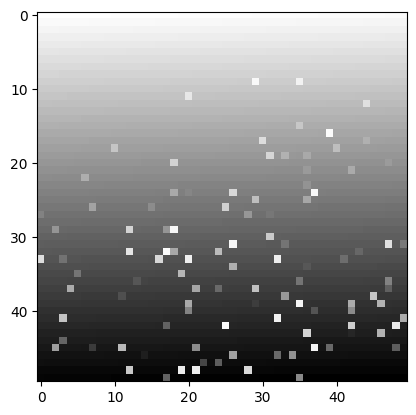

[]

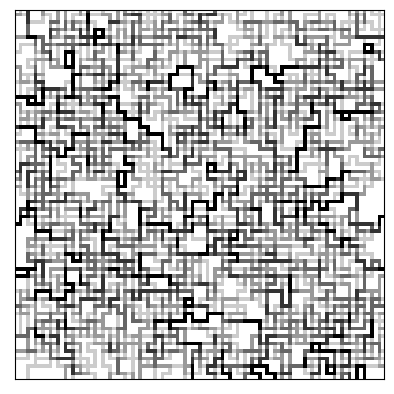

In [6]:
# Example of performing basic simula`tion
m = BasicAxelrodModel(L=50,seed=123 ) # We create a model with our parameters
m.createSystem() # We initialize system
m.plotMap() # Plotting the map before simulation
plt.show()
m.simulate(MCS=600000) # Performing simulation
m.plotBorders() # Plotting the map after simulation
plt.plot()


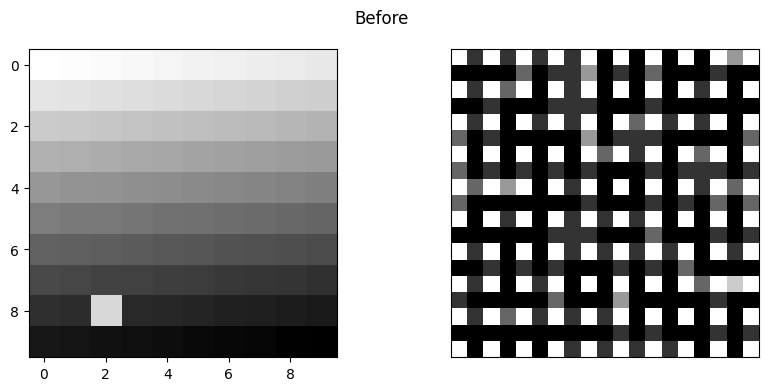

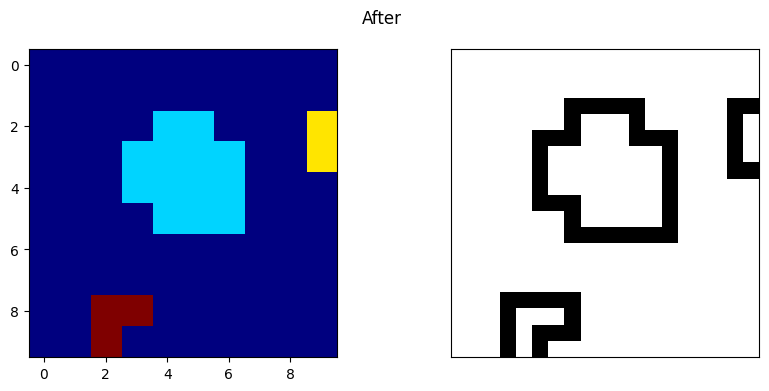

In [9]:
x = BasicAxelrodModel(L=10)
x.createSystem()
plt.figure(figsize=(10,4))
plt.suptitle('Before')
plt.subplot(1,2,1)
x.plotMap()
plt.subplot(1,2,2)
x.plotBorders()
plt.show()
x.simulate(80000)
plt.figure(figsize=(10,4))
plt.suptitle('After')
plt.subplot(1,2,1)
a = x.plotMap('jet')
plt.subplot(1,2,2)
b = x.plotBorders()
plt.show()

In [14]:
x.getRegions()

{7759632296503412586: (1, 84),
 -4371358691848495456: (2, 1),
 6431146137630227440: (3, 15)}

In [27]:
c = np.zeros(100)
M = 20

for _ in range(M):
    x = BasicAxelrodModel(10,5,10)
    x.createSystem()
    for i in range(100): 
        progressBar(i,100,10)
        x.simulate(1000,progress=False)
        c[i] += x.countRegions()


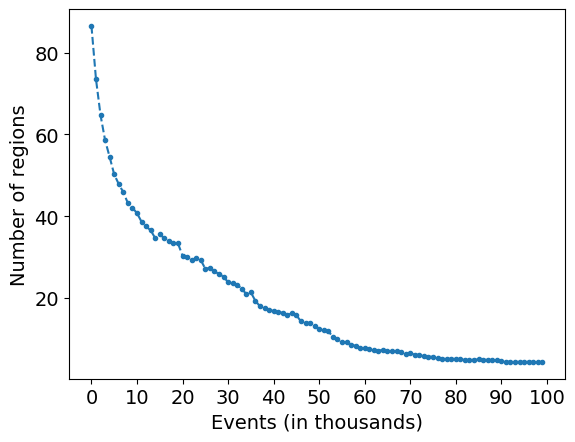

In [33]:

plt.plot(np.arange(0,100000,1000),c/M,'.--')
plt.xlabel('Events (in thousands)')
plt.ylabel('Number of regions')
plt.xticks(np.arange(0,1e5+1,1e4),np.arange(0,101,10))
plt.show()

### Recreating the plots from the article

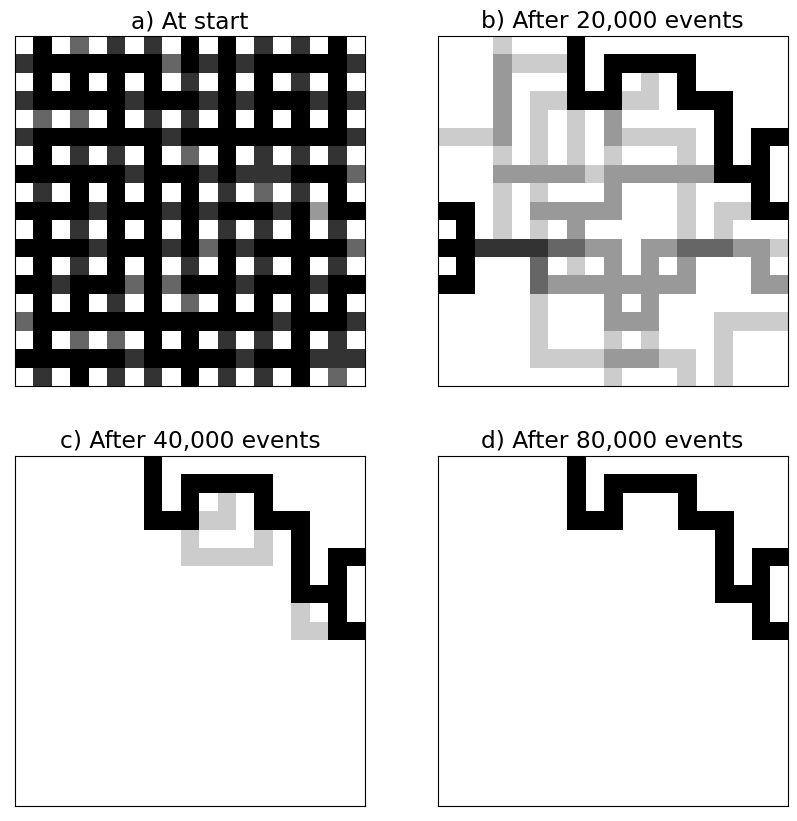

In [13]:
# Borders after 20, 40, 60 and 80 thousands steps for 10x10 system
m = BasicAxelrodModel(10,5,10,seed=1)
m.createSystem()


plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 14})
plt.subplot(2,2,1)
m.plotBorders()
plt.title('a) At start')

plt.subplot(2,2,2)
m.simulate(20000)
m.plotBorders()
plt.title('b) After 20,000 events')

plt.subplot(2,2,3)
m.simulate(20000)
m.plotBorders()
plt.title('c) After 40,000 events')

plt.subplot(2,2,4)
m.simulate(40000)
m.plotBorders()
plt.title('d) After 80,000 events')

plt.show()

In [8]:
# Average number of stable regions:
M = 40
Fs = [5,10,15]
qs = [5,10,15]
r = np.zeros((len(Fs),len(qs)),np.float64)

def process(i,F):
    res = [0]*len(qs)
    for j, q in enumerate(qs):
        for k in range(M):
            m = BasicAxelrodModel(10,F,q)
            m.createSystem()
            m.simulateUntilStable(limit=10000000,step=25000)
            c = m.countRegions()
            res[j] += c
            r[i,j] += c
    return res

res = Parallel(n_jobs=4)(delayed(process)(i, F) for i, F in enumerate(Fs))

r / M

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [16]:
np.savetxt('avg_stable_Fq.txt',(np.array(res)/40),'%.2f')

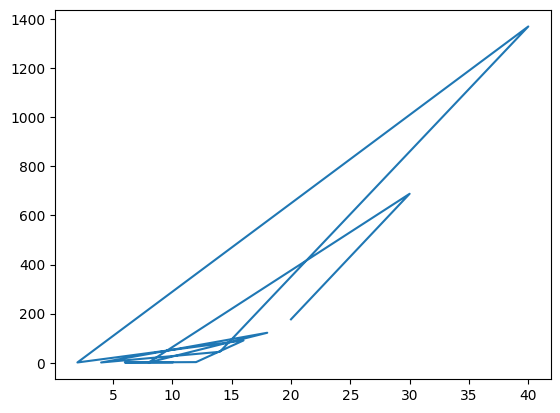

In [21]:
# Number of stable regions vs width of territory
Ls = [2,4,6,8,10,12,14,16,18,20,30,40]
Ls2 = np.random.permutation(Ls)
M = 10
regions = np.zeros(len(Ls), np.int32)

def fun(L):
    res = 0
    for j in range(M):
        m = BasicAxelrodModel(L,15,5)
        m.createSystem()
        m.simulateUntilStable(10000000, step=25000, progress=False)
        res += m.countRegions()
    return res / M

results = Parallel(n_jobs=4)(delayed(fun)(L) for L in Ls2)

results = np.array(results)
plt.plot(Ls2,results)

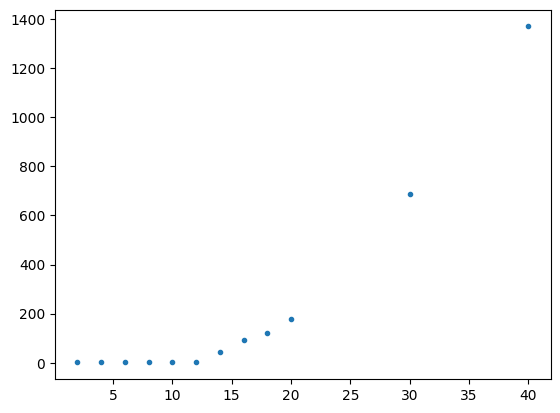

In [22]:
plt.plot(Ls2,results,'.')

In [67]:
# Phase transition
qs = np.arange(4,40,2)
D = np.zeros(len(qs))
nD = np.zeros(len(qs))
M = 80
L = 5

def process(q):
    print(q)
    res1 = 0
    res2 = 0
    for _ in range(M):
        m = BasicAxelrodModel(L,5,q)
        m.createSystem()
        m.simulateUntilStable()
        tmp = m.getRegions()
        res1 += max(tmp.values())
        res2 += len(tmp)
    return res1, res2

results = Parallel(n_jobs=4)(delayed(process)(q) for q in qs)


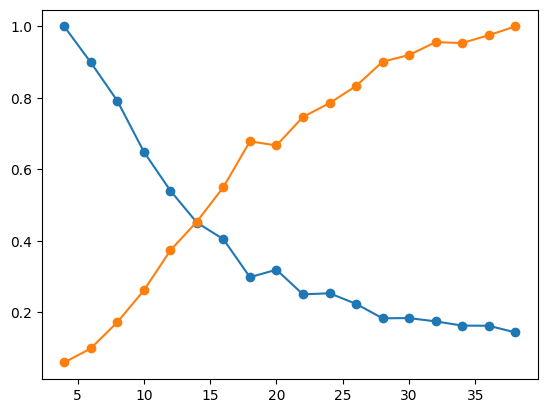

In [68]:
D = np.array(results,np.float64)[:,0]
nD = np.array(results,np.float64)[:,1]
D /= max(D)
nD /= max(nD)

import pandas as pd
x = pd.DataFrame({'q':qs, 'D':D, 'nD': nD})
x.to_csv('phasetrans_L5_F5_M80.csv')

plt.plot(qs,D,'o-')
plt.plot(qs,nD,'o-')
plt.show()

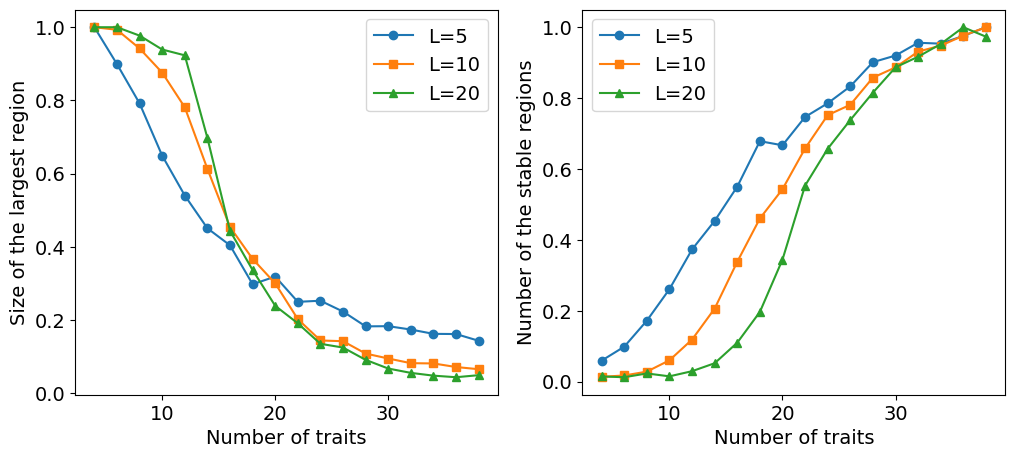

In [16]:
p1 = pd.read_csv('phasetrans_L5_F5_M80.csv')
p2 = pd.read_csv('phasetrans_L10_F5_M40.csv')
p3 = pd.read_csv('phasetrans_L20_F5_M10.csv')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(p1.q, p1.D, 'o-')
plt.plot(p2.q, p2.D, 's-')
plt.plot(p3.q, p3.D, '^-')
plt.xlabel('Number of traits')
plt.legend(['L=5','L=10','L=20'])
plt.ylabel('Size of the largest region')
plt.subplot(1,2,2)
plt.plot(p1.q, p1.nD, 'o-')
plt.plot(p2.q, p2.nD, 's-')
plt.plot(p3.q, p3.nD, '^-')
plt.xlabel('Number of traits')
plt.legend(['L=5','L=10','L=20'])
plt.ylabel('Number of the stable regions')
plt.show()

In [26]:
m = BasicAxelrodModel(14,5,10)
m.createSystem()
m.simulateUntilStable(10000000,25000,True)

array([[1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],


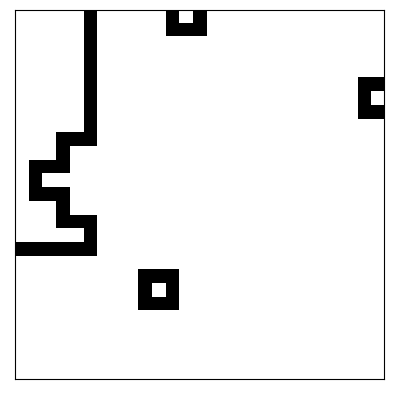

In [27]:
m.plotBorders()

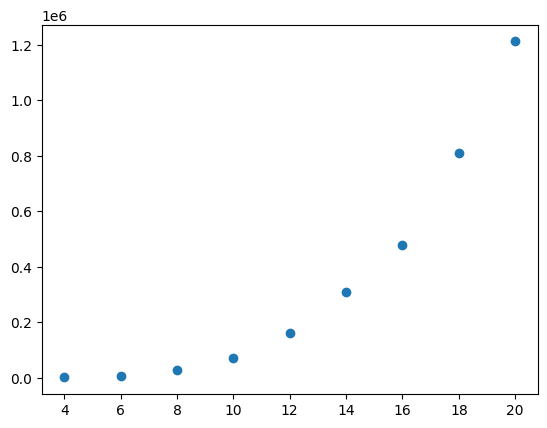

In [31]:
# Time needed for stability
Ls = [4,6,8,10,12,14,16,18,20]
Ls2 = np.random.permutation(Ls)

def process(L):
    M = 20 if L < 15 else 10
    r = 0
    for _ in range(M):
        m = BasicAxelrodModel(L,5,10)
        m.createSystem()
        r += m.simulateUntilStable(10000000,1000)
    return r / M
        
results = Parallel(4)(delayed(process)(L) for L in Ls2)

plt.plot(Ls2,results,'o')
plt.show()

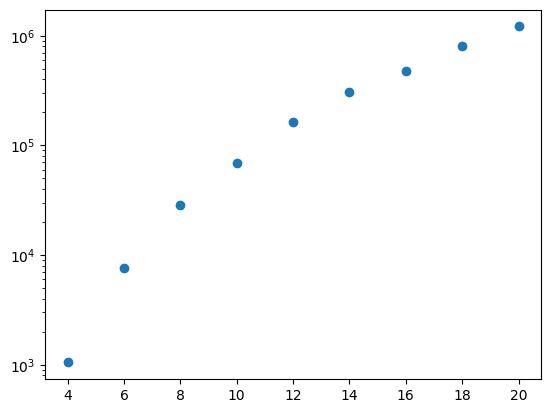

In [32]:


plt.plot(Ls2,results,'o')
plt.yscale('log')
plt.show()

In [34]:
z = np.array((sorted(zip(Ls2,results),key=lambda x: x[0])))
np.savetxt('stability_time_F5_q10.txt')

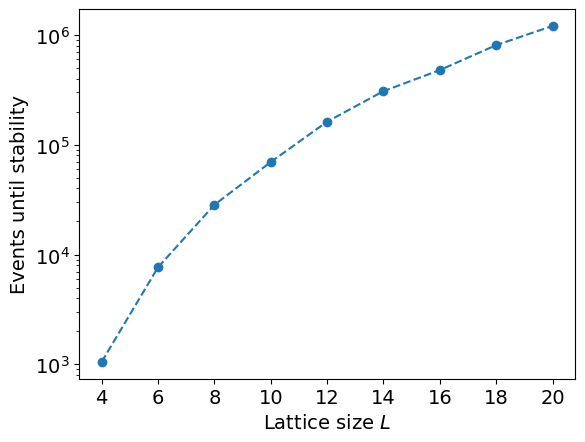

In [35]:
z = np.loadtxt('stability_time_F5_q10.txt')
plt.plot(z[:,0],z[:,1],'o--')
plt.yscale('log')
plt.xlabel('Lattice size $L$')
plt.ylabel('Events until stability')
plt.xticks(np.arange(4,21,2))
plt.title
plt.show()